# JARTIC dataset - Exploratory Data Analysis

Analysis of the traffic dataset with the missing values by each feature for model development.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


## Data Overview

In [2]:

# Path to JARTIC data - expected to be in project data folder
# Note: Place the jp_jartic_processed_20230101_to_20231231.csv file in the ../data/ directory
df = pd.read_csv("../data/jp_jartic_processed_20230101_to_20231231.csv", parse_dates=['timestamp'])
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

Dataset shape: 8,677,621 rows × 13 columns
Memory usage: 2.86 GB


In [3]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8677621 entries, 0 to 8677620
Data columns (total 13 columns):
 #   Column              Dtype              
---  ------              -----              
 0   timestamp           datetime64[ns, UTC]
 1   h3_index_res8       object             
 2   avg_traffic_volume  float64            
 3   max_traffic_volume  int64              
 4   traffic_volume_std  float64            
 5   measurement_count   int64              
 6   avg_distance        float64            
 7   unique_links        int64              
 8   h3_lat_res8         float64            
 9   h3_lon_res8         float64            
 10  prefecture          object             
 11  data_source         object             
 12  country             object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), object(4)
memory usage: 860.7+ MB


,avg_traffic_volume,max_traffic_volume,traffic_volume_std,measurement_count,avg_distance,unique_links,h3_lat_res8,h3_lon_res8
count,8.677621e+06,8.677621e+06,8.119435e+06,8.677621e+06,8.677621e+06,8.677621e+06,8.677621e+06,8.677621e+06
mean,2.693803e+01,5.756698e+01,1.379109e+01,3.518982e+01,5.191792e+01,3.486862e+01,3.580111e+01,1.366581e+02
std,2.219352e+01,5.444943e+01,1.164406e+01,6.188027e+01,4.651530e+01,6.157868e+01,2.867557e+00,3.869053e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.612238e+01,1.276863e+02
25%,6.972222e+00,1.600000e+01,4.353410e+00,5.000000e+00,2.837097e+01,5.000000e+00,3.420964e+01,1.334354e+02
50%,2.300000e+01,4.400000e+01,1.086319e+01,1.300000e+01,4.081707e+01,1.300000e+01,3.537383e+01,1.371892e+02
75%,4.234000e+01,8.200000e+01,2.027763e+01,3.600000e+01,5.928000e+01,3.600000e+01,3.654506e+01,1.399405e+02
max,2.880000e+02,9.440000e+03,9.075989e+02,6.940000e+02,7.300000e+02,6.940000e+02,4.537708e+01,1.444370e+02


In [4]:
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"Unique timestamps: {df['timestamp'].nunique():,}")
print(f"Unique hexagons: {df['h3_index_res8'].nunique():,}")
print(f"Average records per hexagon: {len(df) / df['h3_index_res8'].nunique():.0f}")

Time range: 2022-12-31 15:00:00+00:00 to 2023-12-31 14:00:00+00:00
Duration: 364 days
Unique timestamps: 8,760
Unique hexagons: 1,017
Average records per hexagon: 8533


Time range: Covers exactly one year, from the end of 2022 to the end of 2023.

Duration: 364 days — almost full year, maybe missing one day.

Unique timestamps: 8,760 → this matches hourly data for a non-leap year (24 × 365 = 8,760). Good consistency.
Unique hexagons: 1,017 → that’s your spatial coverage at H3 res8.

Average records per hexagon: 8,533 → slightly less than 8,760, so some hexagons are missing a few timestamps.

In [5]:
time_diff = df.groupby('h3_index_res8')['timestamp'].apply(lambda x: x.sort_values().diff().dt.total_seconds() / 3600)
print(f"Sampling frequency (hours between measurements):")
print(time_diff.dropna().value_counts().head(10))

Sampling frequency (hours between measurements):
timestamp
1.0     8651841
2.0       13631
3.0        3148
16.0       2404
4.0        1505
5.0         765
14.0        740
10.0        585
6.0         464
7.0         262
Name: count, dtype: int64


Results: Occasional missing timestamps per hexagon, need to fill or impute these gaps (using mean, median, interpolation, or forward-fill) so that every hexagon has a consistent hourly record.

## Missing Values

In [6]:
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing %', ascending=False)
missing_stats

,Missing Count,Missing %
traffic_volume_std,558186,6.43


In [7]:
df = df.dropna(subset=['traffic_volume_std'])
df = df.drop(columns=['traffic_volume_std'])

In [8]:
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing %', ascending=False)
missing_stats

,Missing Count,Missing %


## Hexagon completeness of JARTIC traffic data

Latitude range: 26.12 to 45.38
Longitude range: 127.69 to 144.44


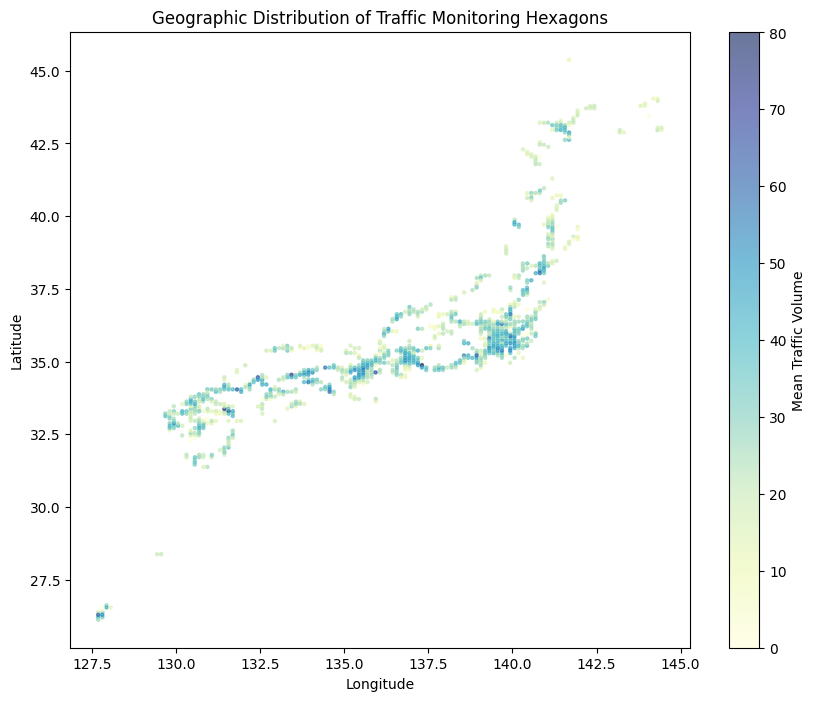

In [10]:
hex_stats_traffic = df.groupby('h3_index_res8').agg({
    'avg_traffic_volume': ['count', 'mean', 'std'],
    'h3_lat_res8': 'first',
    'h3_lon_res8': 'first'
})
hex_stats_traffic.columns = ['traffic_count', 'traffic_mean', 'traffic_std', 'lat', 'lon']


print(f"Latitude range: {hex_stats_traffic['lat'].min():.2f} to {hex_stats_traffic['lat'].max():.2f}")
print(f"Longitude range: {hex_stats_traffic['lon'].min():.2f} to {hex_stats_traffic['lon'].max():.2f}")


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    hex_stats_traffic['lon'],
    hex_stats_traffic['lat'],
    c=hex_stats_traffic['traffic_mean'],
    cmap='YlGnBu',
    s=5,
    alpha=0.6
)
plt.colorbar(scatter, label='Mean Traffic Volume')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Traffic Monitoring Hexagons')
plt.show()


## Hourly / Daily Patterns

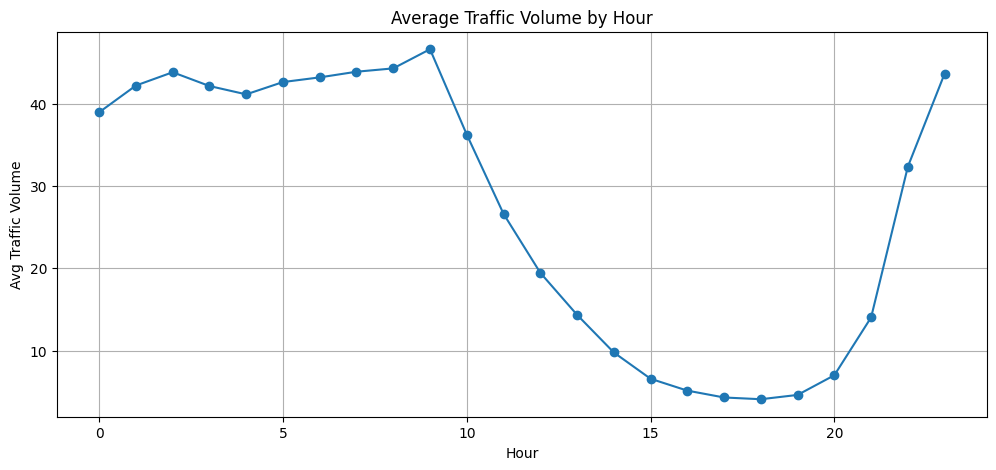

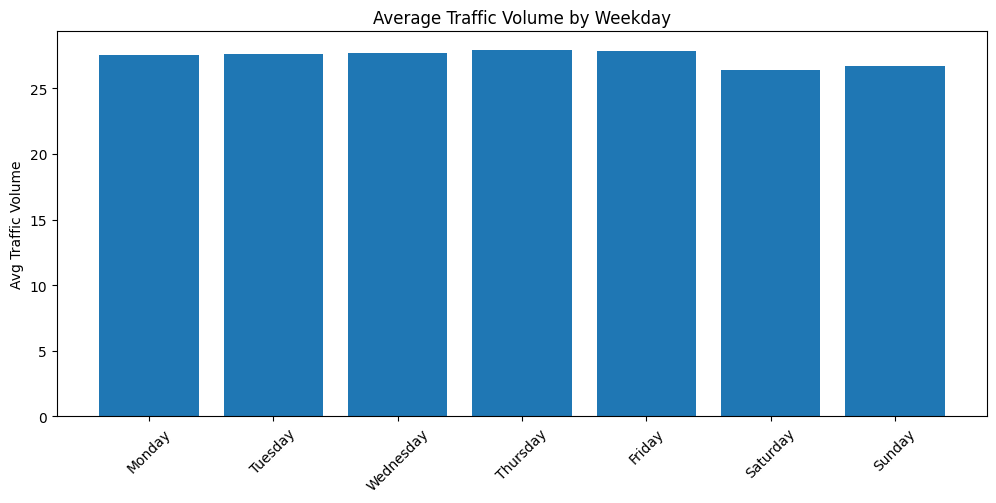

In [11]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()

hourly_avg = df.groupby('hour')['avg_traffic_volume'].mean()
weekday_avg = df.groupby('weekday')['avg_traffic_volume'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

plt.figure(figsize=(12,5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title("Average Traffic Volume by Hour")
plt.xlabel("Hour")
plt.ylabel("Avg Traffic Volume")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.bar(weekday_avg.index, weekday_avg.values)
plt.title("Average Traffic Volume by Weekday")
plt.ylabel("Avg Traffic Volume")
plt.xticks(rotation=45)
plt.show()

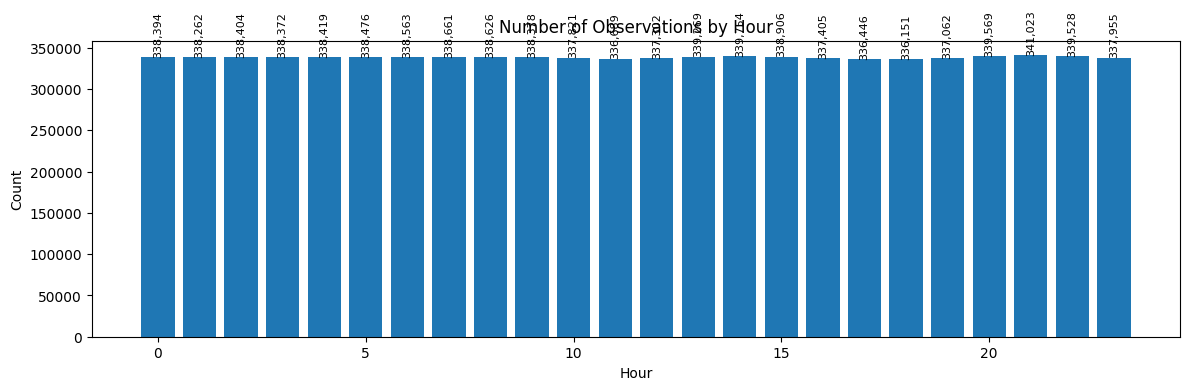

In [12]:
hourly_count = df.groupby('hour')['avg_traffic_volume'].count()

plt.figure(figsize=(12,4))
bars = plt.bar(hourly_count.index, hourly_count.values)
plt.title("Number of Observations by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:,}',
             ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()
